### 自适应阈值
+ Task.1 Otsu阈值法
+ Task.2 迭代阈值法

In [109]:
from copy import copy
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
from PIL import Image
import math
import time

In [110]:
#srcImg 为灰度图像
def OtsuThreshold(srcImg):
    besThres = 0
    fmax = 0
    h,w = srcImg.shape
    #Step.1 建立直方图
    histogram = np.zeros(256)
    for y in range(h):
        for x in range(w):
            histogram[srcImg[y][x]] += 1
    #Step.2 确定搜索范围
    gmin = 0
    gmax = 255
    while histogram[gmin] == 0 : gmin += 1
    while histogram[gmax] == 0 : gmax -= 1
    if gmin == gmax : return -1
    #Step.3 初始化 两类的个数与均值
    s1 = n1 = 0
    s2 = n2 = 0
    for i in range(gmin,gmax+1):
        s2 += histogram[i] * i
        n2 += histogram[i]
    count = n2
    #Step.4 对最佳阈值进行搜索
    for i in range(gmin,gmax):
        if histogram[i] == 0 : continue
        #更新s1,s2
        s1 += histogram[i] * i
        s2 -= histogram[i] * i
        #更新n1,n2
        n1 += histogram[i]
        n2 -= histogram[i]
        #计算评价函数
        dist = (s1*1.0/n1 - s2 * 1.0/n2)
        f = dist * dist * (n1*1.0/count) * (n2*1.0/count)
        if f > fmax :
            fmax = f
            besThres = i
    return besThres + 1

In [111]:
#srcImg 为 灰度图
def IterativeThresHold(srcImg,diffT):
    h,w = srcImg.shape
    #Step.1 建立直方图
    histogram = np.zeros(256)
    for y in range(h):
        for x in range(w):
            histogram[srcImg[y][x]] += 1
    #Step.2 确定搜索范围
    gmin = 0
    gmax = 255
    while histogram[gmin] == 0: gmin += 1
    while histogram[gmax] == 0: gmax -= 1
    if gmin == gmax : return -1
    #Step.3 初始化阈值T0为中值,并初始化两类的平均数和个数
    middleCount = h * w // 2
    n1 = n2 = 0
    s1 = s2 = 0
    prevT = curT = 0
    flag = False
    for i in range(gmin,gmax+1):
        n2 += histogram[i]
        s2 += histogram[i] * i
        #初始化阈值T0为灰度中值
        if n2 > middleCount :
            if flag == False:
                flag = True
                curT = i
    for i in range(gmin,curT):
        #更新n1,n2
        n1 += histogram[i]
        n2 -= histogram[i]
        #更新s1,s2
        s1 += histogram[i] * i
        s2 -= histogram[i] * i
    prevT = curT
    curT = 1/2.0*(s1/n1+s2/n2)
    #Step.4 进行迭代直至两次阈值间隔小于给定值
    while abs(curT - prevT) > diffT:
        curT = np.uint8(curT + 0.5)
        #print("curT:{},prevT:{}".format(curT,prevT))
        if curT > prevT:
            for i in range(prevT,curT):
                #更新n1,n2
                n1 += histogram[i]
                n2 -= histogram[i]
                #更新s1,s2
                s1 += histogram[i] * i
                s2 -= histogram[i] * i
        else:
            for i in range(curT,prevT):
                #更新n1,n2
                n1 -= histogram[i]
                n2 += histogram[i]
                #更新s1,s2
                s1 -= histogram[i] * i
                s2 += histogram[i] * i             
        prevT = curT
        curT = 1/2.0*(s1/n1+s2/n2)

    return curT + 1


OtusThres:139
IterativeThres:139.26476314759702
OtsuRunTime:0.41739059999999883
IterativeRunTime:0.3719781099999636


(Text(0.5, 1.0, 'Otsu Img'), ([], []), ([], []))

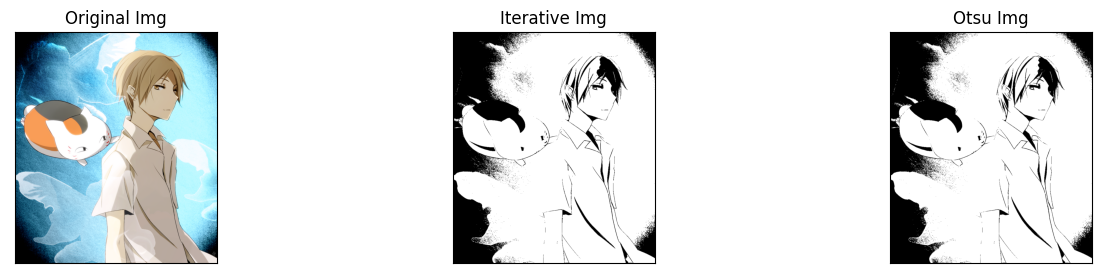

In [112]:
image_path = r"1.png"  #图片路径
#读取图像
srcImg = cv2.imread(image_path)
srcImgShow = cv2.cvtColor(srcImg,cv2.COLOR_RGB2BGR)
GryImg = cv2.cvtColor(srcImg, cv2.COLOR_BGR2GRAY)
OtsuImg = copy.deepcopy(GryImg)
IterativeImg = copy.deepcopy(GryImg)
start = time.perf_counter()
for i in range(10):
    IterativeThres = IterativeThresHold(GryImg,1)
end = time.perf_counter()
IterativeRunTime = (end - start)/10
start = time.perf_counter()
for i in range(10):
    OtsuThres = OtsuThreshold(GryImg)
end = time.perf_counter()
OtsuRunTime = (end - start)/10
h,w = GryImg.shape
for y in range(h):
    for x in range(w):
        if OtsuImg[y][x] >= OtsuThres:
            OtsuImg[y][x] = 255
        else:
            OtsuImg[y][x] = 0
        if IterativeImg[y][x] >= IterativeThres:
            IterativeImg[y][x] = 255
        else:
            IterativeImg[y][x] = 0
print("OtusThres:{}".format(OtsuThres))
print("IterativeThres:{}".format(IterativeThres))
print("OtsuRunTime:{}".format(OtsuRunTime))
print("IterativeRunTime:{}".format(IterativeRunTime))

plt.figure(figsize=(16,3))
plt.subplot(131),plt.imshow(srcImgShow,cmap='gray')
plt.title("Original Img"), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(IterativeImg,cmap='gray')
plt.title("Iterative Img"), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(OtsuImg,cmap='gray')
plt.title("Otsu Img"), plt.xticks([]), plt.yticks([])

我将每个分割方法都循环十遍比较两个算法的时间，得出以下结论：
+ Otus阈值法和迭代阈值法都进行了优化，两个算法的平均值和个数的更新都是采用了和上次迭代的基础上进行更新，并没有重新计算。
+ 实验结果表明迭代阈值法和Otsu阈值法最后得到的阈值近似都是139，但是迭代阈值法的时间比Otsu阈值法略快，这和我之前的直觉不一样。我认为首先是迭代阈值的初值的计算就已经大大缩减了算法的收敛时间，再者Otsu阈值必须遍历完所有可能的灰度值，而迭代阈值法类似二分搜索。